In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer,Conv2D,Dense,MaxPool2D,Flatten , BatchNormalization,Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives,FalseNegatives, TruePositives, TrueNegatives, Precision,Recall,AUC,F1Score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteNJNX2H/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [6]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

train_dataset,val_dataset,test_dataset= splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

In [7]:
for data in dataset[0].take(3):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

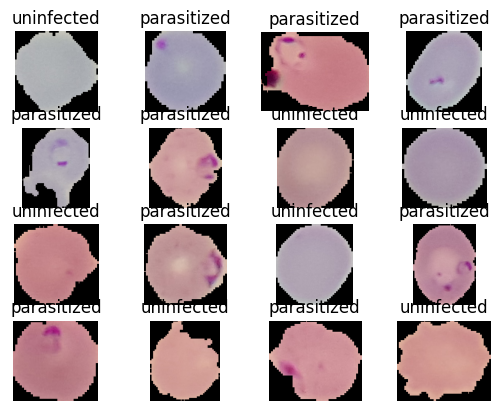

In [8]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [9]:
IMAGE_SIZE = 224
def resizing(image,label):
  return tf.image.resize(image,(IMAGE_SIZE,IMAGE_SIZE))/255.0,label

In [10]:
train_dataset = train_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)

In [ ]:
for d in train_dataset.take(3):
  print(d)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [ ]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=6,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Conv2D(filters=16,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Flatten(),

    Dense(100,activation="relu"),
    BatchNormalization(),
    Dense(10,activation="relu"),
    BatchNormalization(),
    Dense(1,activation="sigmoid")


])
lenet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

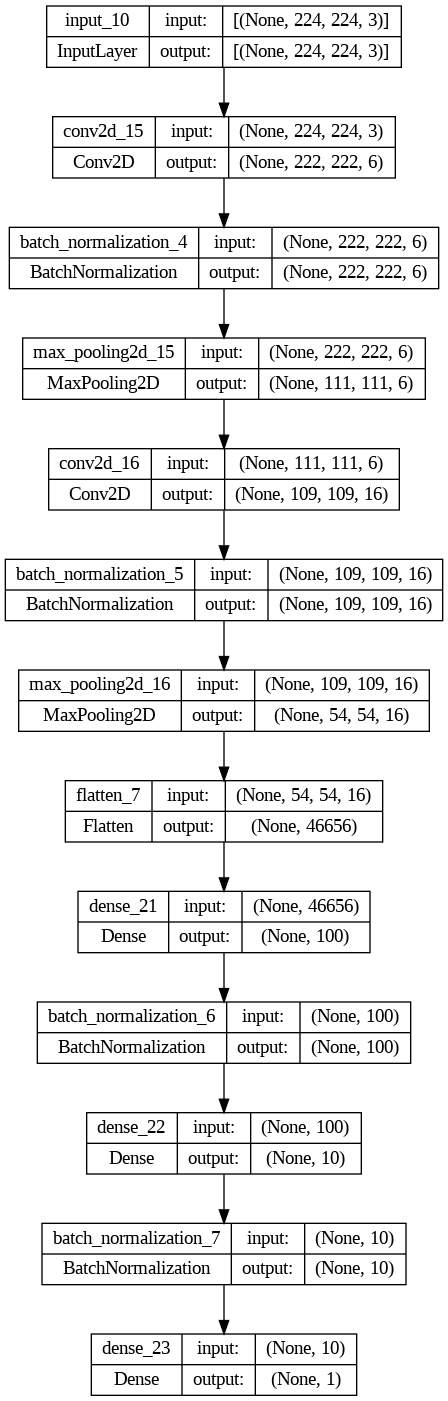

In [ ]:
tf.keras.utils.plot_model(lenet_model,to_file='model_1.png',show_shapes=True)

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy'
              )

In [ ]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 42s 60ms/step - loss: 0.2206 - accuracy: 0.9235 - val_loss: 0.4613 - val_accuracy: 0.8421
Epoch 2/20
689/689 [==============================] - 54s 78ms/step - loss: 0.2577 - accuracy: 0.9077 - val_loss: 1.6025 - val_accuracy: 0.4966
Epoch 3/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2577 - accuracy: 0.9098 - val_loss: 7.5997 - val_accuracy: 0.8791
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.2026 - accuracy: 0.9322 - val_loss: 0.1872 - val_accuracy: 0.9350
Epoch 5/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1708 - accuracy: 0.9418 - val_loss: 0.1574 - val_accuracy: 0.9441
Epoch 6/20
689/689 [==============================] - 40s 58ms/step - loss: 0.1593 - accuracy: 0.9479 - val_loss: 0.1803 - val_accuracy: 0.9441
Epoch 7/20
689/689 [==============================] - 41s 60ms/step - loss: 0.1519 - accuracy: 0.9499 - val_loss: 0.1607 - val_accuracy:

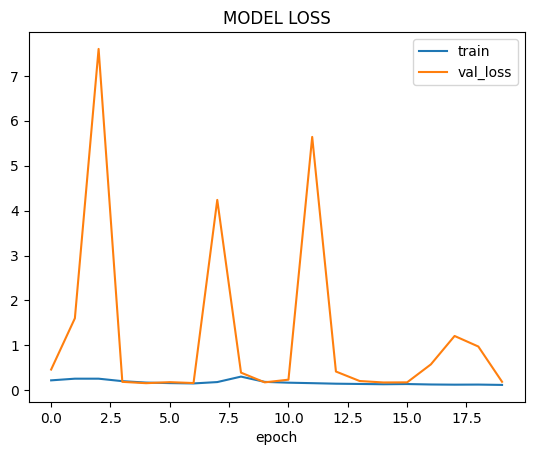

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

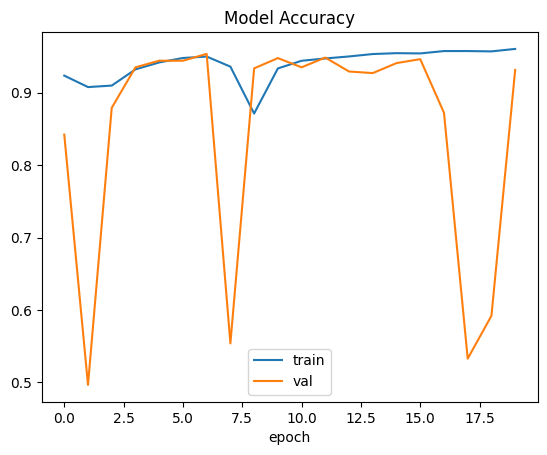

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

In [19]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

5512/5512 [==============================] - 30s 4ms/step - loss: 0.2001 - accuracy: 0.9307


[0.20005926489830017, 0.9306966662406921]

In [ ]:
ch(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 8s 8s/step


'parasite'

In [ ]:
def ch(x):
  if(x<0.5):
    return str('parasite')
  else:
    return "uneffected"

1/1 [==============================] - 0s 18ms/step


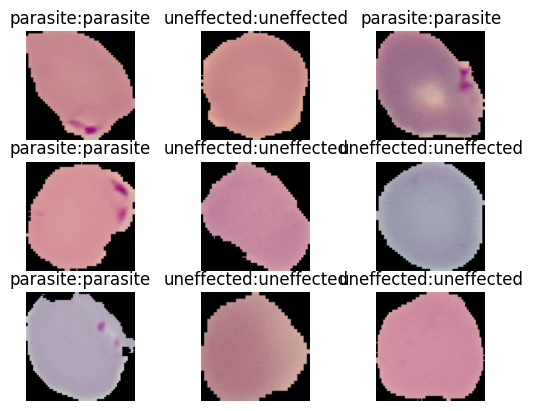

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(ch(label.numpy()[0]))+":" + str(ch(lenet_model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
lenet_model.save("lenet")

In [ ]:
lenet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
func_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3), name="Input Image")

x = Conv2D(filters=6,kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)
x = Flatten()(x)

x = Dense(100,activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation="sigmoid")(x)

lenet_func_model = Model(func_input,func_output, name = "Lenet_func_model")
lenet_func_model.summary()

Model: "Lenet_func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16) 

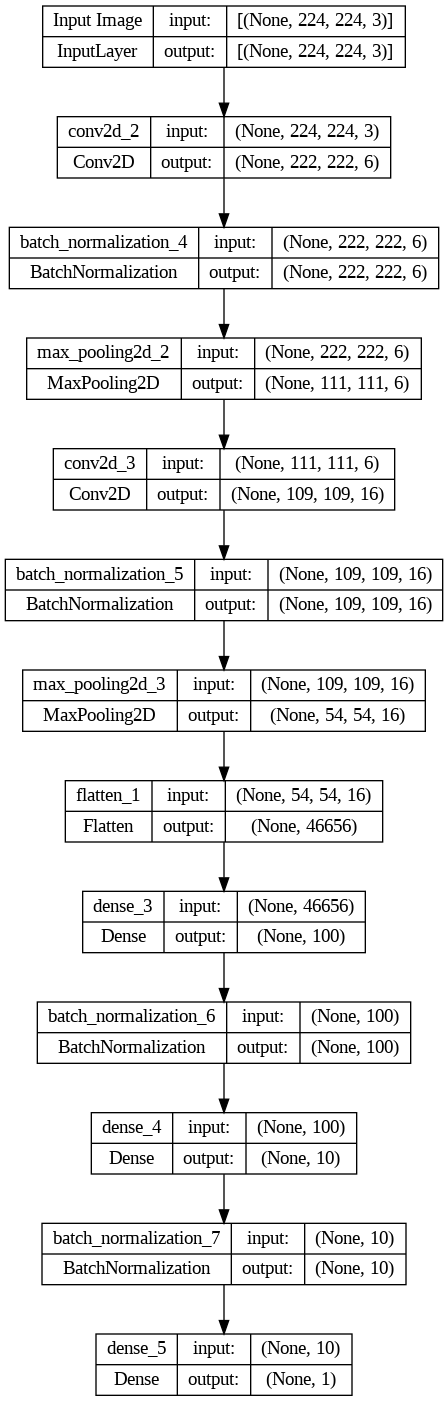

In [15]:
tf.keras.utils.plot_model(lenet_func_model,to_file='model_1.png',show_shapes=True)

In [16]:
lenet_func_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy'
              )

In [20]:
history = lenet_func_model.fit(train_dataset,validation_data=val_dataset,epochs=2,verbose=1)

Epoch 1/2
689/689 [==============================] - 48s 70ms/step - loss: 0.2833 - accuracy: 0.8923 - val_loss: 0.3404 - val_accuracy: 0.8984
Epoch 2/2
689/689 [==============================] - 49s 71ms/step - loss: 0.1979 - accuracy: 0.9351 - val_loss: 0.1888 - val_accuracy: 0.9390


In [ ]:
#feature extractor model and calling it;

In [28]:
func_in = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3), name="Input Image")

x = Conv2D(filters=6,kernel_size = 3, strides=1, padding='valid', activation='relu')(func_in)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2,strides=2)(x)


feature_extractor = Model(func_in,output, name = "Feature_Extractor")
feature_extractor.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_22 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_23 (Ba  (None, 109, 109, 16)

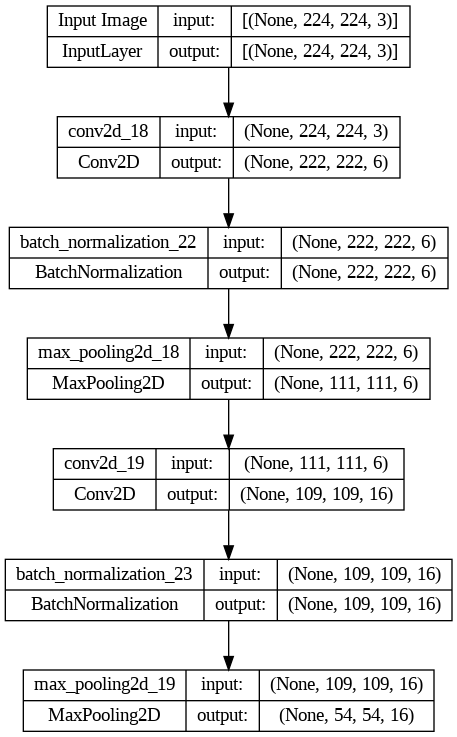

In [29]:
tf.keras.utils.plot_model(feature_extractor,to_file='feature_extractor.png',show_shapes=True)

In [31]:
abc = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name='Input Image')
x = feature_extractor(abc)
x = Flatten()(x)

x = Dense(100,activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation="sigmoid")(x)

lenet_func = Model(abc,func_output,name='lenet_func')
lenet_func.summary()

Model: "lenet_func"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_26 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1

In [32]:
seq_feature_extractor = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=6,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Conv2D(filters=16,kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),



])
seq_feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_28 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_29 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                        

In [33]:
abc = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name='Input Image')
x = seq_feature_extractor(abc)
x = Flatten()(x)

x = Dense(100,activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation="sigmoid")(x)

lenet_func = Model(abc,func_output,name='lenet_func')
lenet_func.summary()

Model: "lenet_func"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 54, 54, 16)        1136      
                                                                 
 flatten_4 (Flatten)         (None, 46656)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_30 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                        

In [40]:
class FeatureExtractor(Layer):
  def __init__(self,filters,kernal_size,strides,padding,activation,pool_size):
    super(FeatureExtractor,self).__init__()
    func_in = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3), name="Input Image")

    self.conv_1 = Conv2D(filters=filters,kernel_size = kernal_size, strides= strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size,strides=2*strides
                            )

    self.conv_2 =Conv2D(filters=2*filters,kernel_size = kernal_size, strides= strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=2,strides=2*strides)

  def call(self,x):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8,3,1,'valid','relu',2)

In [41]:
func_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3), name="Input Image")

x = feature_sub_classed(func_input)
x = Flatten()(x)

x = Dense(100,activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation="sigmoid")(x)

lenet_func_model_sb = Model(func_input,func_output, name = "Lenet_func_model_sb")
lenet_func_model_sb.summary()

Model: "Lenet_func_model_sb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_38 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 10)        

In [47]:
class Lenet(Model):
  def __init__(self):
    super(Lenet,self).__init__()

    self.feature_extractor = FeatureExtractor(8,3,1,"valid","relu",2)
    self.flatten = Flatten()
    self.dense1 = Dense(100,activation="relu")
    self.batch1 = BatchNormalization()
    self.dense2 = Dense(10,activation="relu")
    self.batch2 = BatchNormalization()
    self.dense3 = Dense(1,activation="sigmoid")



  def call(self,x,training):
    x=self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x= self.batch1(x)
    x = self.dense2(x)
    x= self.batch2(x)
    x = self.dense3(x)

    return x
lenet_sub_classed = Lenet()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_5 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_50 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_51 (Ba  multiple                  40  

In [54]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),BinaryAccuracy(name='acc'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [56]:
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics
              )

In [57]:
history = lenet_sub_classed.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5
689/689 [==============================] - 52s 68ms/step - loss: 0.1139 - tp: 10724.0000 - fp: 564.0000 - tn: 10458.0000 - fn: 300.0000 - acc: 0.9608 - precision: 0.9500 - recall: 0.9728 - auc: 0.9898 - val_loss: 0.2695 - val_tp: 1185.0000 - val_fp: 54.0000 - val_tn: 1310.0000 - val_fn: 206.0000 - val_acc: 0.9056 - val_precision: 0.9564 - val_recall: 0.8519 - val_auc: 0.9755
Epoch 2/5
689/689 [==============================] - 55s 80ms/step - loss: 0.1038 - tp: 10710.0000 - fp: 493.0000 - tn: 10527.0000 - fn: 316.0000 - acc: 0.9633 - precision: 0.9560 - recall: 0.9713 - auc: 0.9918 - val_loss: 0.5790 - val_tp: 604.0000 - val_fp: 51.0000 - val_tn: 1312.0000 - val_fn: 788.0000 - val_acc: 0.6955 - val_precision: 0.9221 - val_recall: 0.4339 - val_auc: 0.9501
Epoch 3/5
689/689 [==============================] - 45s 66ms/step - loss: 0.0925 - tp: 10786.0000 - fp: 453.0000 - tn: 10572.0000 - fn: 235.0000 - acc: 0.9688 - precision: 0.9597 - recall: 0.9787 - auc: 0.9929 - val_loss: 0.

In [59]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [61]:
lenet_sub_classed.evaluate(test_dataset)

5512/5512 [==============================] - 41s 5ms/step - loss: 0.6532 - tp: 1281.0000 - fp: 132.0000 - tn: 2625.0000 - fn: 1474.0000 - acc: 0.7086 - precision: 0.9066 - recall: 0.4650 - auc: 0.9375


[0.6532174944877625,
 1281.0,
 132.0,
 2625.0,
 1474.0,
 0.708635687828064,
 0.9065817594528198,
 0.46497276425361633,
 0.9374797940254211]

In [71]:
labels =[]
inp =[]
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [68]:
print(labels)

[array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), arr

In [69]:
labels = np.array([i[0] for i in labels])

In [70]:
print(labels)

[1 0 1 ... 0 1 1]


In [ ]:
predicted = lenet_sub_classed.predict(np.array(inp)[:,0,...])

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels,predicted,threshold)
print(cm )